In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyuvdata import UVBeam, ShortDipoleBeam, BeamInterface
from pyuvdata.datasets import fetch_data
from pyuvdata.utils.plotting import get_az_za_grid, plot_beam_arrays

# filename = fetch_data("mwa_full_EE")
filename = "/Users/bryna/Projects/Physics/PyFHD/PyFHD/resources/instrument_config/mwa_full_embedded_element_pattern.h5"

mwa_beam = UVBeam.from_file(filename, pixels_per_deg=1, beam_type="efield")
dipole_beam = ShortDipoleBeam()

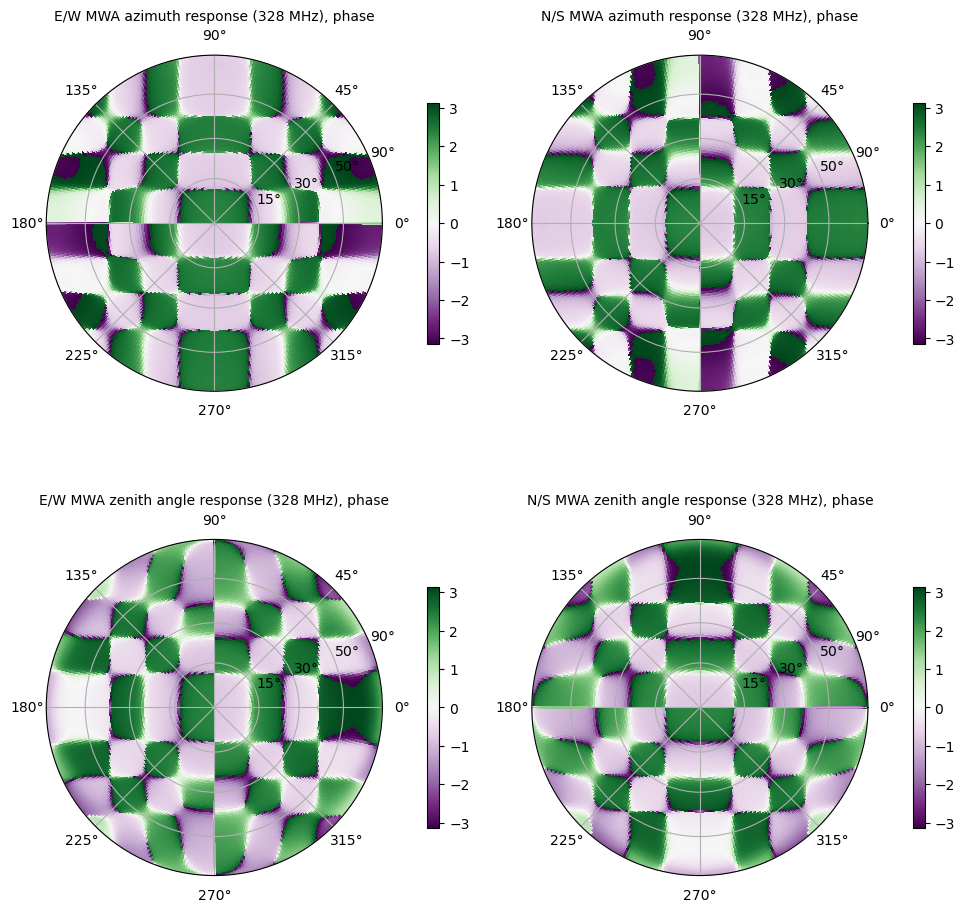

In [2]:
mwa_beam.plot(freq_ind=-1, complex_type="phase")

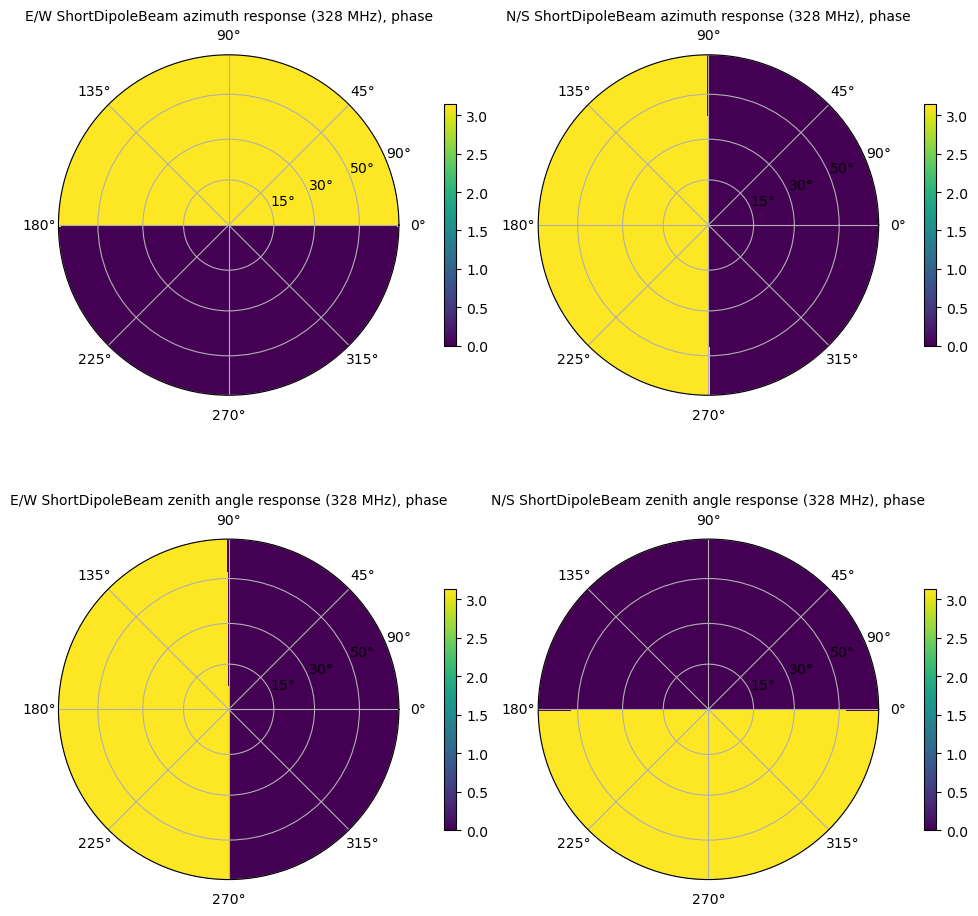

In [3]:
dipole_beam.plot(beam_type="efield", freq=mwa_beam.freq_array[-1], complex_type="phase")

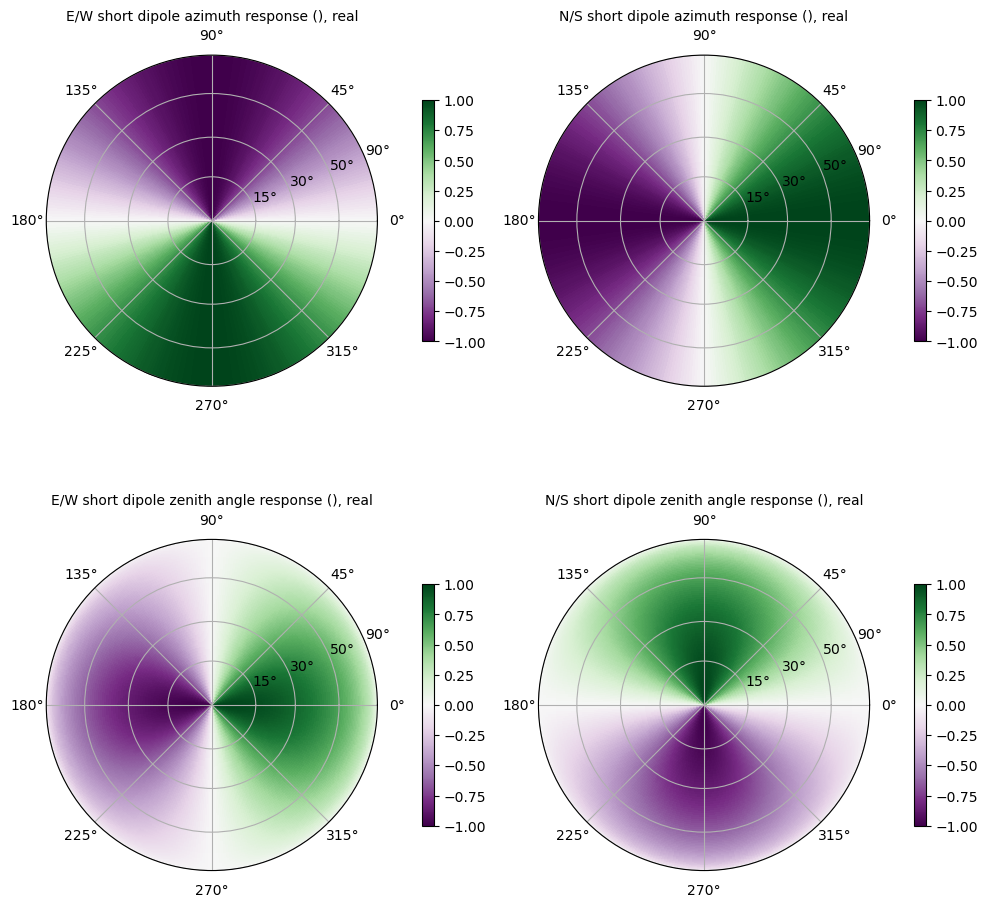

In [4]:
az_grid, za_grid = get_az_za_grid()
az_array, za_array = np.meshgrid(az_grid, za_grid)

bi = BeamInterface(dipole_beam, beam_type="efield")
beam_vals = bi.compute_response(
    az_array=az_array.flatten(),
    za_array=za_array.flatten(),
    freq_array=np.asarray(np.asarray([mwa_beam.freq_array[-1]])),
)
beam_vals = beam_vals.reshape(2, 2, za_grid.size, az_grid.size)

feed_labels = np.degrees(dipole_beam.feed_angle).astype(str)
feed_labels[np.isclose(dipole_beam.feed_angle, 0)] = "N/S"
feed_labels[np.isclose(dipole_beam.feed_angle, np.pi / 2)] = "E/W"

plot_beam_arrays(
    beam_vals,
    az_array,
    za_array,
    complex_type="real",
    feedpol_label=feed_labels,
    beam_type_label="E-field",
    beam_name="short dipole",
)

In [5]:
zenith_slice = np.nonzero(za_array==za_array.min())

flip_beam_vals = np.copy(beam_vals)
for va_i in range(dipole_beam.Naxes_vec):
    for f_i in range(dipole_beam.Nfeeds):
        az_flip = np.angle(beam_vals[va_i, f_i, *zenith_slice])==np.pi
        flip_beam_vals[va_i, f_i, :, np.nonzero(az_flip)] *= -1


In [6]:
beam_vals[va_i, f_i, *zenith_slice].shape

(360,)

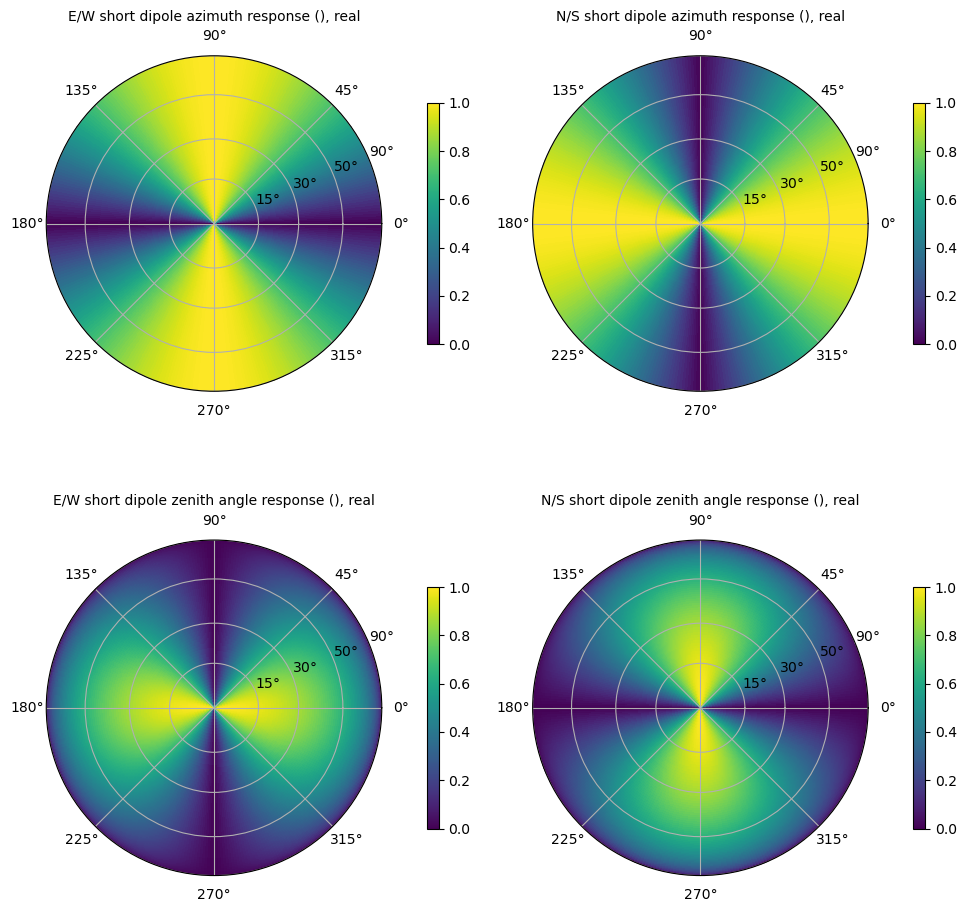

In [7]:
plot_beam_arrays(
    flip_beam_vals,
    az_array,
    za_array,
    complex_type="real",
    feedpol_label=feed_labels,
    beam_type_label="E-field",
    beam_name="short dipole",
)

In [8]:
delay = np.sum(flip_beam_vals, axis=0)
delay = delay/np.abs(delay)
delay = delay[np.newaxis]

In [9]:
print(delay.min(), delay.max())

(0.9999999999999999+0j) (1+0j)


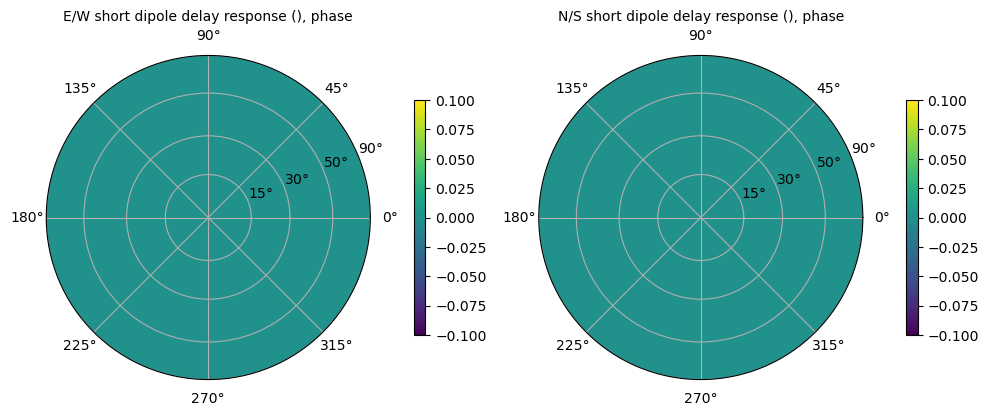

In [10]:
plot_beam_arrays(
    delay,
    az_array,
    za_array,
    complex_type="phase",
    feedpol_label=feed_labels,
    beam_type_label="delay",
    beam_name="short dipole",
)

In [11]:
# Redo for MWA beam
zenith_ind = np.nonzero(mwa_beam.axis2_array==mwa_beam.axis2_array.min())
f_ind=1

flip_mwa_beam = np.copy(mwa_beam.data_array)
for va_i in range(mwa_beam.Naxes_vec):
    for f_i in range(mwa_beam.Nfeeds):
        az_angles = np.angle(np.squeeze(flip_mwa_beam[va_i, f_i, :, zenith_ind]))
        az_angles[az_angles<0] += 2 * np.pi
        az_angle_diff = abs(az_angles - np.unwrap(az_angles, period=np.pi))
        az_flip = np.logical_and(az_angle_diff > 1, az_angle_diff < 4)
        # az_flip is shape (Nfreqs, Naxis1), need to reorder to get those axes adjacent
        flip_mwa_beam = np.transpose(flip_mwa_beam, axes=(0, 1, 2, 4, 3))
        flip_mwa_beam[va_i, f_i, az_flip] *= -1
        # now switch back
        flip_mwa_beam = np.transpose(flip_mwa_beam, axes=(0, 1, 2, 4, 3))
        # check if zenith response is all negative now, if so make it positive
        # print(np.min(flip_mwa_beam[va_i, f_i,:, zenith_ind]), np.max(flip_mwa_beam[va_i, f_i,:, zenith_ind]))
        mean_zen_val = np.mean(np.squeeze(flip_mwa_beam[va_i, f_i,:, zenith_ind].real), axis=-1)
        flip_mwa_beam[va_i, f_i, mean_zen_val< 0] *= -1


In [12]:
flip_mwa_beam.shape

(2, 2, 218, 91, 360)

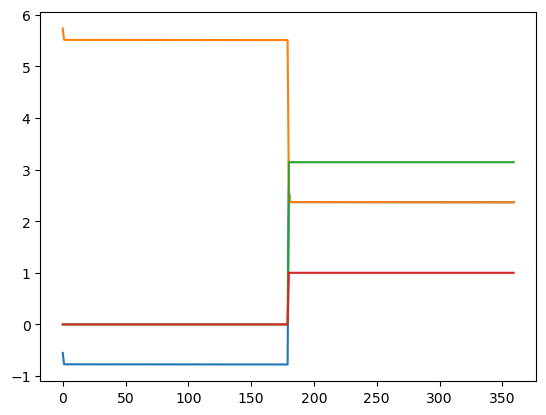

In [13]:
va_i = 1
f_i = 1

az_angles = np.angle(np.squeeze(mwa_beam.data_array[va_i, f_i, -1, zenith_ind]))
az_angles[az_angles<0] += 2 * np.pi
az_angle_diff = abs(az_angles - np.unwrap(az_angles, period=np.pi))
az_flip = az_angle_diff > np.pi/2

plt.plot(np.angle(np.squeeze(mwa_beam.data_array[va_i, f_i, -1, zenith_ind])))
plt.plot(az_angles)
plt.plot(az_angle_diff)
plt.plot(np.logical_and(az_angle_diff > 1, az_angle_diff < 4))



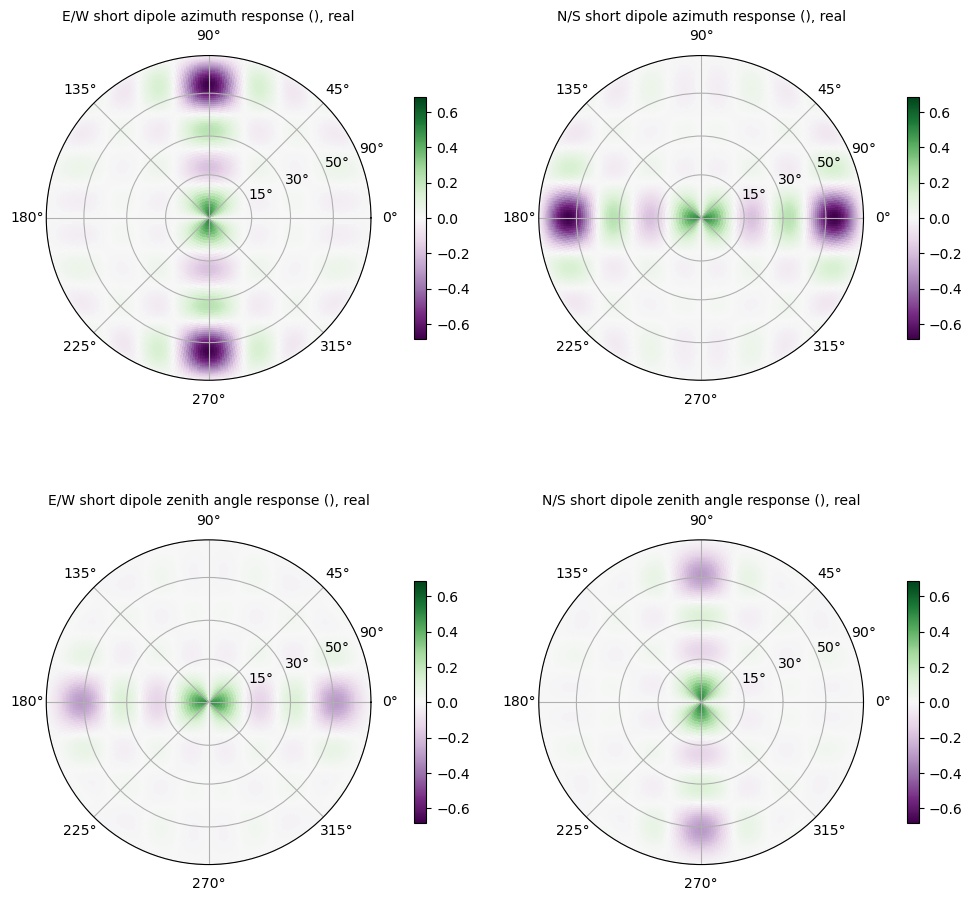

In [14]:
plot_beam_arrays(
    flip_mwa_beam[:,:,-1],
    az_array,
    za_array,
    complex_type="real",
    feedpol_label=feed_labels,
    beam_type_label="E-field",
    beam_name="short dipole",
)

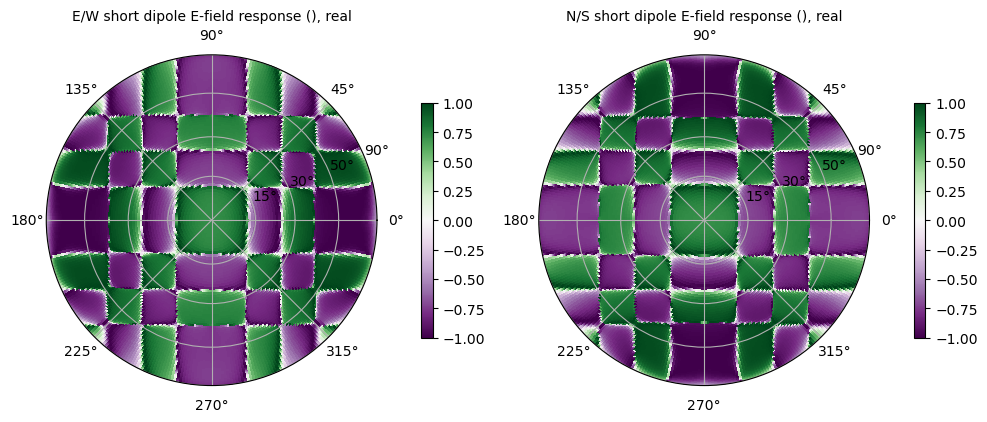

In [15]:
delay = np.sum(flip_mwa_beam, axis=0)
delay = delay[np.newaxis]
delay = delay / np.abs(delay)
plot_beam_arrays(
    delay[:,:,-1],
    az_array,
    za_array,
    complex_type="real",
    feedpol_label=feed_labels,
    beam_type_label="E-field",
    beam_name="short dipole",
)

In [16]:
f_mag = np.sqrt(np.sum(np.abs(mwa_beam.data_array)**2, axis=0))
f_mag = f_mag[np.newaxis]

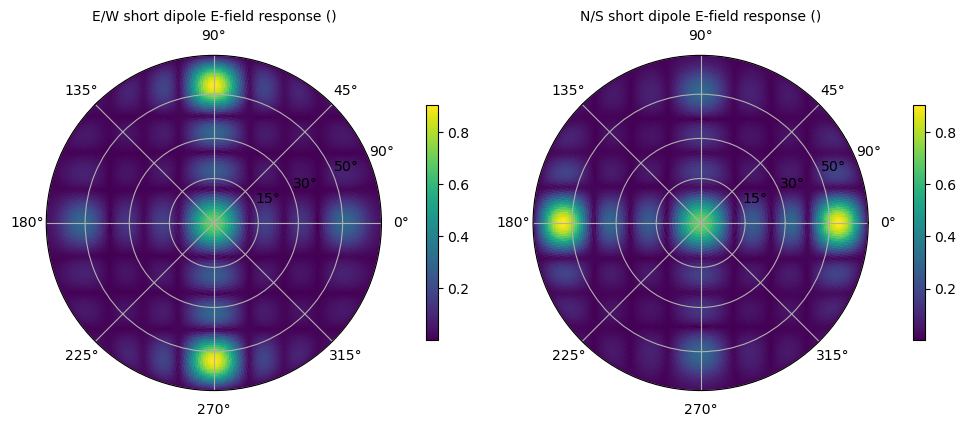

In [17]:
plot_beam_arrays(
    f_mag[:,:,-1],
    az_array,
    za_array,
    complex_type="real",
    feedpol_label=feed_labels,
    beam_type_label="E-field",
    beam_name="short dipole",
)

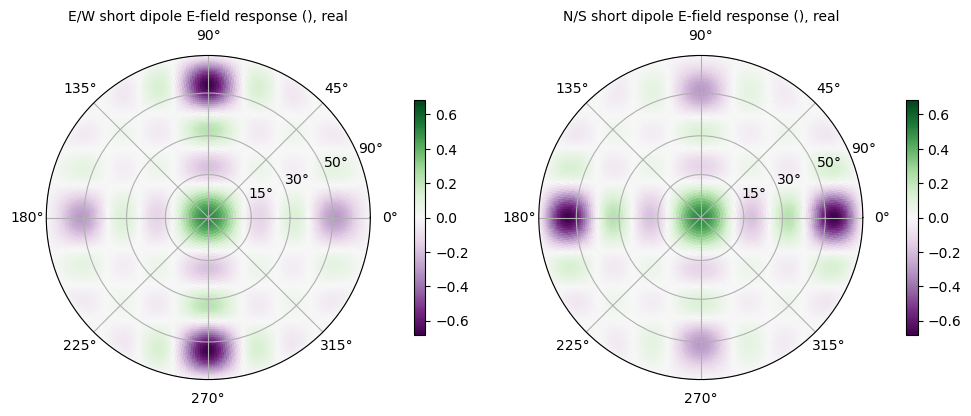

In [18]:
f_full = f_mag * delay
plot_beam_arrays(
    f_full[:,:,-1],
    az_array,
    za_array,
    complex_type="real",
    feedpol_label=feed_labels,
    beam_type_label="E-field",
    beam_name="short dipole",
)

In [19]:
k_arr = np.copy(mwa_beam.data_array)
for va_i in range(mwa_beam.Naxes_vec):
    for f_i in range(mwa_beam.Nfeeds):
        k_arr[va_i, f_i] /= f_full[0, f_i]


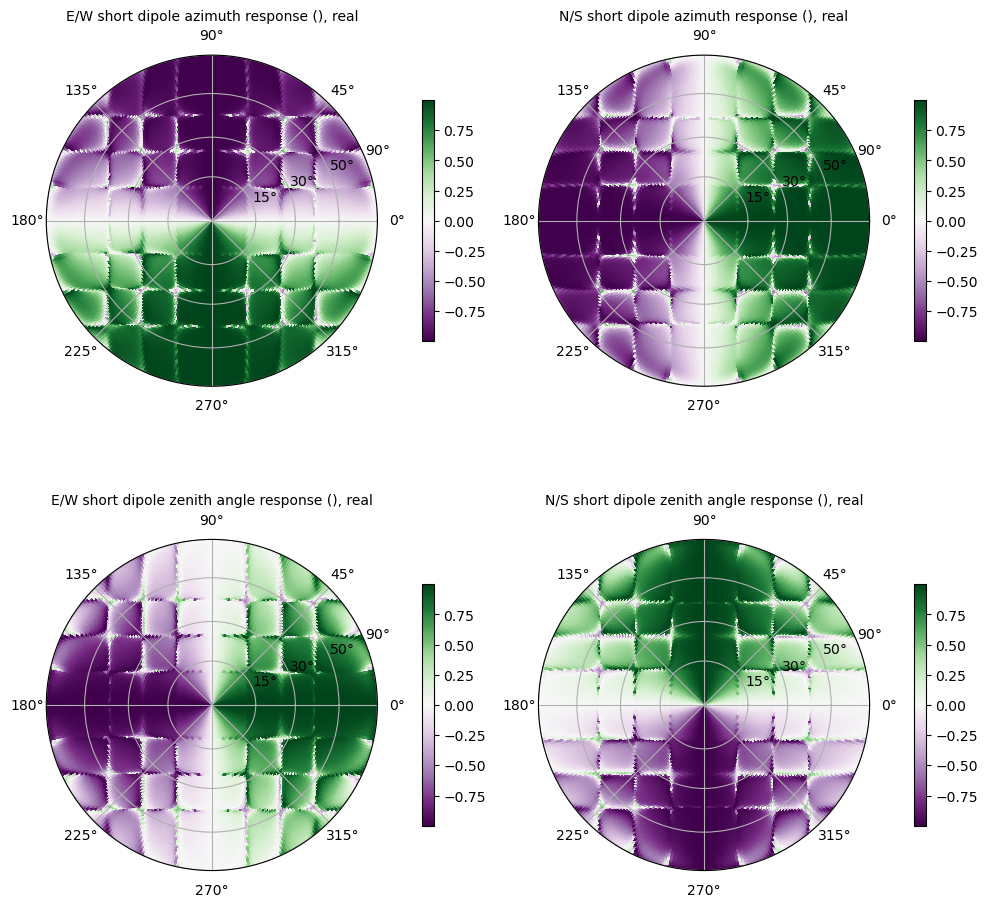

In [20]:
plot_beam_arrays(
    k_arr[:,:,-1],
    az_array,
    za_array,
    complex_type="real",
    feedpol_label=feed_labels,
    beam_type_label="E-field",
    beam_name="short dipole",
)

In [21]:
firesp, fproj = mwa_beam.decompose_feed_iresponse_projection()

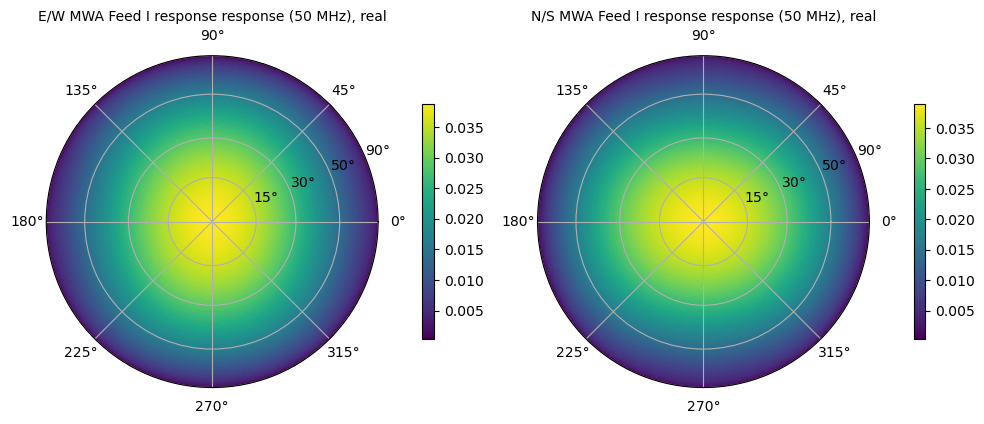

In [22]:
firesp.plot(freq_ind=0, complex_type="real")

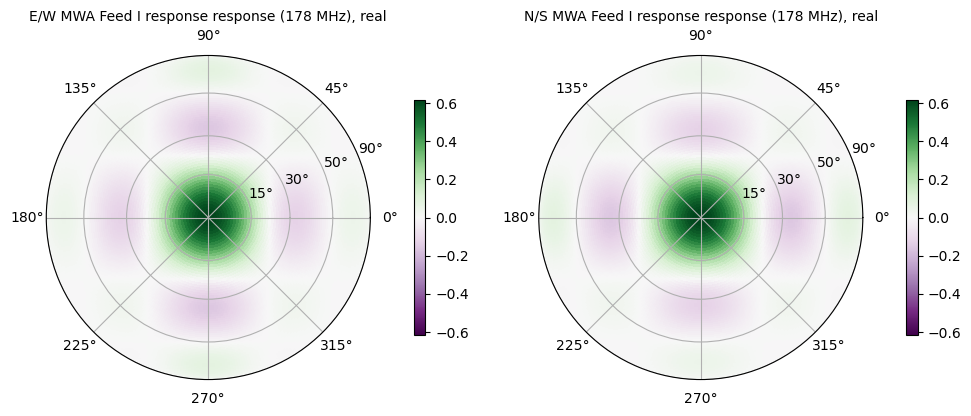

In [27]:
firesp.plot(freq_ind=100, complex_type="real")

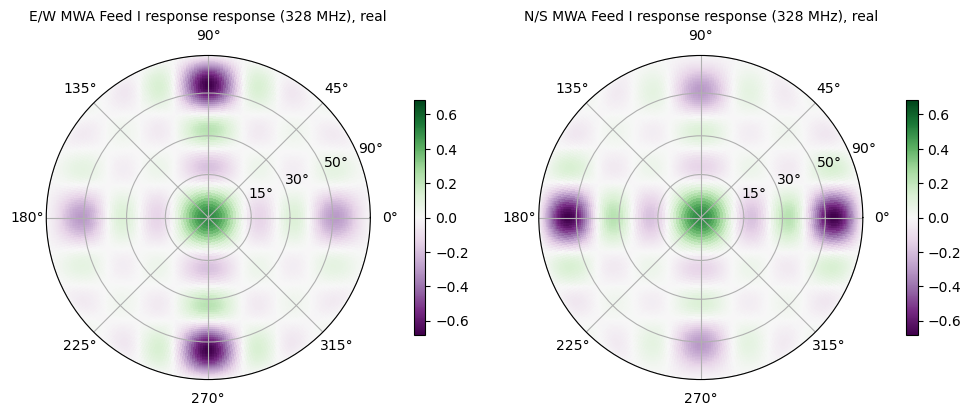

In [23]:
firesp.plot(freq_ind=-1, complex_type="real")

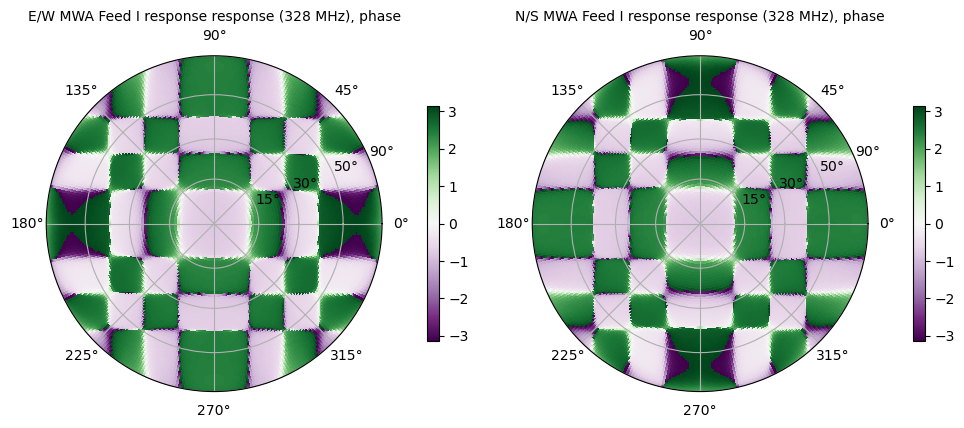

In [28]:
firesp.plot(freq_ind=-1, complex_type="phase")

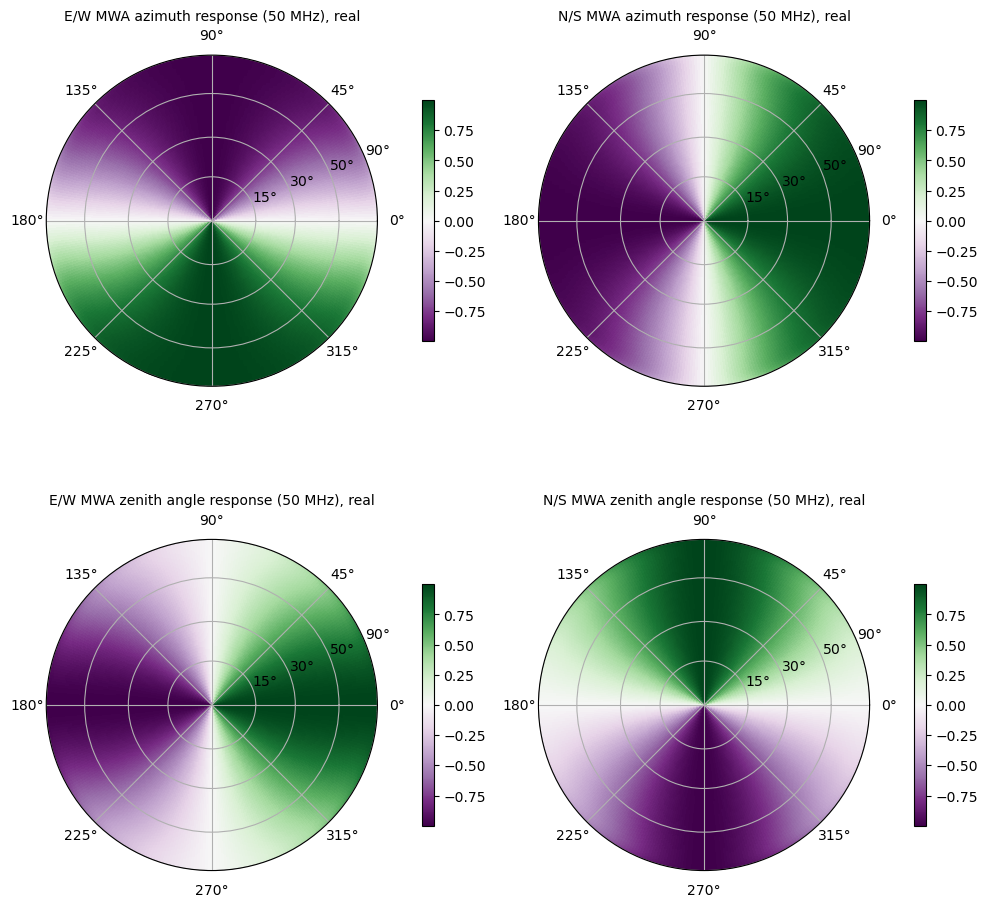

In [24]:
fproj.plot(freq_ind=0, complex_type="real")

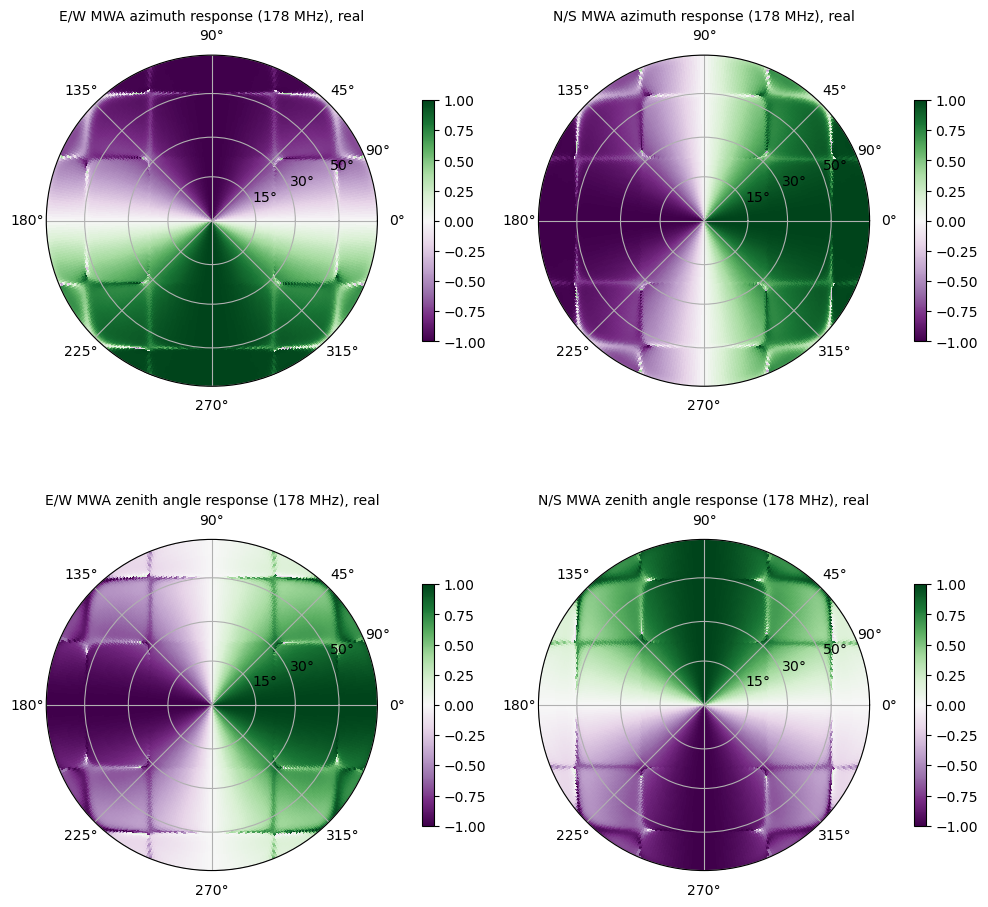

In [26]:
fproj.plot(freq_ind=100, complex_type="real")

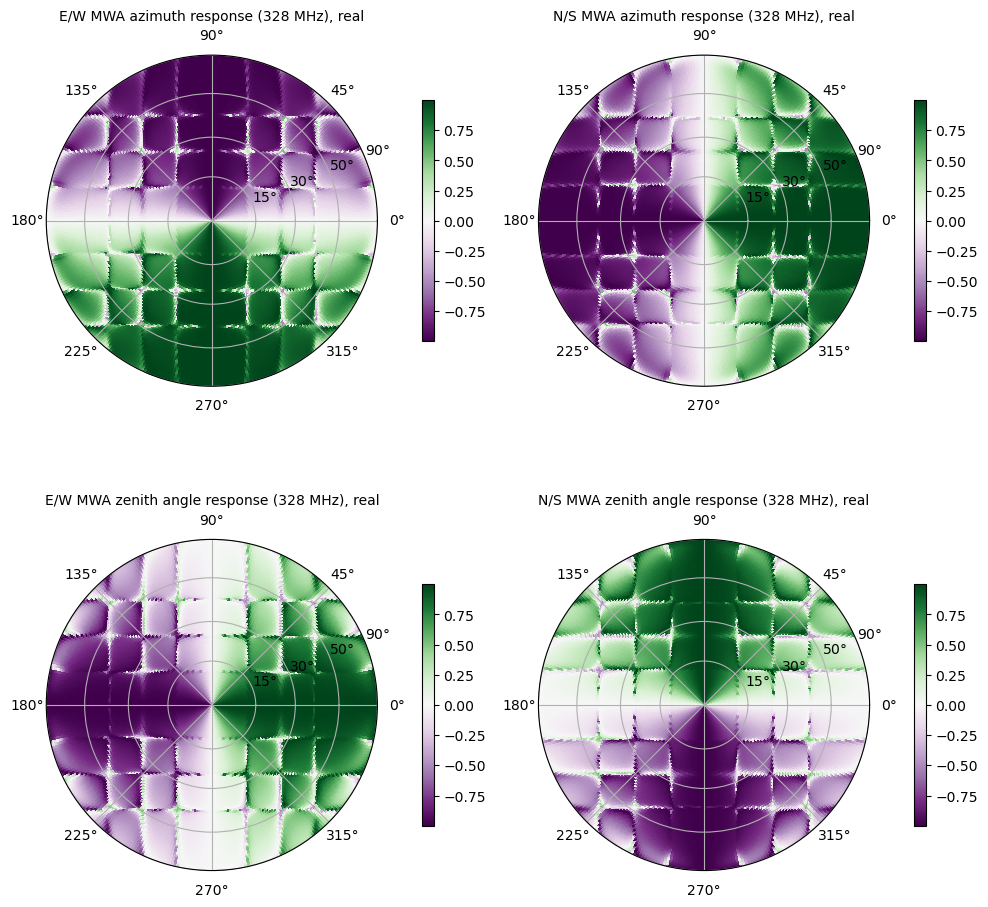

In [25]:
fproj.plot(freq_ind=-1, complex_type="real")